In [689]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [690]:
df = pd.read_csv("../data/homework-02-housing.csv")

In [691]:
WORK_COLS = ['latitude',
'longitude',
'housing_median_age',
'total_rooms',
'total_bedrooms',
'population',
'households',
'median_income',
'median_house_value']

In [692]:
df = df[WORK_COLS]

In [693]:
df.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

In [694]:
df["population"].median()

1166.0

In [695]:
def split_data(df, seed):
    df_len = len(df)
    df_idx = np.arange(df_len)
    assert df_len == len(df_idx)
    #print(df_len, df_idx)

    np.random.seed(seed)
    np.random.shuffle(df_idx)
    #print(df_idx)

    train_len = int(df_len * 0.6)
    val_len = int(df_len * 0.2)
    test_len = df_len - (train_size + val_size)
    assert df_len == (train_len + val_len + test_len)
    #print(train_len, val_len, test_len)

    df_train = df.iloc[df_idx[:train_len]]
    df_val = df.iloc[df_idx[train_len:train_len + val_len]]
    df_test = df.iloc[df_idx[train_len + val_len:]]

    assert len(df_train) == train_len and len(df_val) == val_len and len(df_test) == test_len

    y_train = df_train["median_house_value"]
    y_val = df_val["median_house_value"]
    y_test = df_test["median_house_value"]

    del df_train["median_house_value"]
    del df_val["median_house_value"]
    del df_test["median_house_value"]

    assert "median_house_value" not in df_train.columns.values
    assert "median_house_value" not in df_val.columns.values
    assert "median_house_value" not in df_test.columns.values

    y_train = np.log1p(y_train.values)
    y_val = np.log1p(y_val.values)
    y_test = np.log1p(y_test.values)
    
    return df_train, df_val, df_test, y_train, y_val, y_test

In [696]:
df_train, df_val, df_test, y_train, y_val, y_test = split_data(df, 42)

In [697]:
def train(_X, _y, _reg):
    # w = inv(XT * X) * XT * y
    _X = np.column_stack([np.ones(_X.shape[0]), _X])
    _XT = _X.T
    _XTX = _X.T.dot(_X)
    _XTX = _XTX + _reg * np.eye(_XTX.shape[0])
    _XTX_inv = np.linalg.inv(_XTX)
    _w_full = _XTX_inv.dot(_XT).dot(_y)
    return _w_full[0], _w_full[1:]

In [698]:
def prepare(_X, _na_fill):
    return _X.fillna(_na_fill).values

In [699]:
def rmse(_pred, _train):
    return np.sqrt(((_pred - _train) ** 2).mean())

In [700]:
def test_params(_df_train, _y_train, _df_val, _y_val, _na_fill, _reg):
    _w0, _w = train(prepare(_df_train, _na_fill), _y_train, _reg)
    _y_pred = _w0 + prepare(_df_val, _na_fill).dot(_w)
    return round(rmse(_y_pred, _y_val), 2)

In [708]:
print("zero -->", test_params(df_train, y_train, df_val, y_val, 0, 0))
print("mean() -->", test_params(df_train, y_train, df_val, y_val, df_train.total_bedrooms.mean(), 0))

zero --> 0.34
mean() --> 0.34


In [703]:
for reg in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    print(reg, "-->", test_params(df_train, y_train, df_val, y_val, 0, reg))

0 --> 0.33
1e-06 --> 0.33
0.0001 --> 0.33
0.001 --> 0.33
0.01 --> 0.33
0.1 --> 0.33
1 --> 0.33
5 --> 0.34
10 --> 0.34


In [712]:
errors = []
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    df_train, df_val, df_test, y_train, y_val, y_test = split_data(df, seed)
    err = test_params(df_train, y_train, df_val, y_val, 0, 0)
    errors.append(err)
print(round(np.array(errors).std(), 3))

0.005


In [705]:
df_train, df_val, df_test, y_train, y_val, y_test = split_data(df, 9)
test_params(pd.concat([df_train, df_val]), np.concatenate([y_train, y_val]), df_test, y_test, 0, 0.001)

0.35

136900.0000000001
191788.91917017836


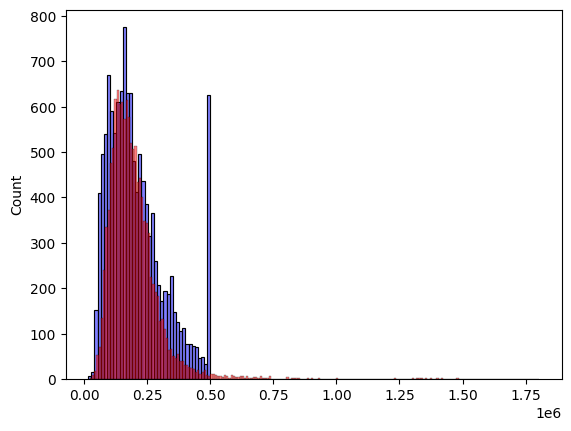

In [734]:
def foo():
    df_train, df_val, df_test, y_train, y_val, y_test = split_data(df, 0)
    na_fill = 0
    w0, w = train(prepare(df_train, na_fill), y_train, 0)
    y_pred = w0 + df_train.fillna(na_fill).values.dot(w)
    print(np.expm1(y_train[0]))
    print(np.expm1(y_pred[0]))
    sns.histplot(np.expm1(y_train), color="blue", alpha=0.5)
    sns.histplot(np.expm1(y_pred), color="red", alpha=0.5)
    
foo()

In [735]:
1+1

2